In [5]:
import numpy as np, pandas as pd, os
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
energy = np.loadtxt('energy.txt')
arr_pos1 = np.loadtxt('cell4pos1.txt')

In [7]:
#Main Algorithm SIMPLISMA
def simplisma(d, nr, error):

    def wmat(c,imp,irank,jvar):
        dm=np.zeros((irank+1, irank+1))
        dm[0,0]=c[jvar,jvar]
        
        for k in range(irank):
            kvar=np.int(imp[k])
            
            dm[0,k+1]=c[jvar,kvar]
            dm[k+1,0]=c[kvar,jvar]
            
            for kk in range(irank):
                kkvar=np.int(imp[kk])
                dm[k+1,kk+1]=c[kvar,kkvar]
                
        return dm

    nrow,ncol=d.shape
    
    dl = np.zeros((nrow, ncol))
    imp = np.zeros(nr)
    mp = np.zeros(nr)
    
    w = np.zeros((nr, ncol))
    p = np.zeros((nr, ncol))
    s = np.zeros((nr, ncol))
    
    error=error/100
    mean=np.mean(d, axis=0)
    error=np.max(mean)*error
    
    s[0,:]=np.std(d, axis=0)
    w[0,:]=(s[0,:]**2)+(mean**2)
    p[0,:]=s[0,:]/(mean+error)

    imp[0] = np.int(np.argmax(p[0,:]))
    mp[0] = p[0,:][np.int(imp[0])]
    
    l=np.sqrt((s[0,:]**2)+((mean+error)**2))

    for j in range(ncol):
        dl[:,j]=d[:,j]/l[j]
        
    c=np.dot(dl.T,dl)/nrow
    
    w[0,:]=w[0,:]/(l**2)
    p[0,:]=w[0,:]*p[0,:]
    s[0,:]=w[0,:]*s[0,:]
    
    print('purest variable 1: ', np.int(imp[0]+1), mp[0])

    for i in range(nr-1):
        for j in range(ncol):
            dm=wmat(c,imp,i+1,j)
            w[i+1,j]=np.linalg.det(dm)
            p[i+1,j]=w[i+1,j]*p[0,j]
            s[i+1,j]=w[i+1,j]*s[0,j]
            
        imp[i+1] = np.int(np.argmax(p[i+1,:]))
        mp[i+1] = p[i+1,np.int(imp[i+1])]
        
        print('purest variable '+str(i+2)+': ', np.int(imp[i+1]+1), mp[i+1])
        
    sp_arr=np.zeros((nrow, nr))
    
    for i in range(nr):
        sp_arr[0:nrow,i]=d[0:nrow,np.int(imp[i])]
        
    plt.subplot(3, 1, 2)
    plt.plot(sp_arr)
    plt.title('Estimate Components')
    
    concs = np.dot(np.linalg.pinv(sp_arr), d)
    
    plt.subplot(3, 1, 3)
    for i in range(nr):
        plt.plot(concs[i])
    plt.title('Concentrations')
    plt.show()
    
    return sp_arr, concs

purest variable 1:  54 0.4035698438727566
purest variable 2:  2 0.0009946009750513398
purest variable 3:  83 7.648855210299699e-08


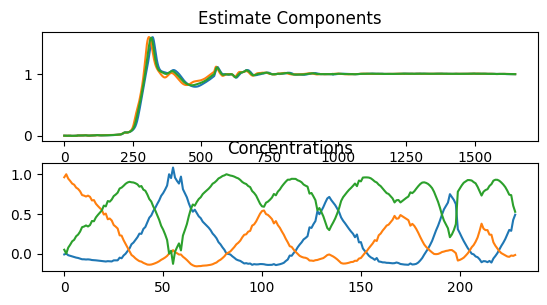

In [8]:
#Run Simplisma
sp_arr, concs = simplisma(np.transpose(arr_pos1), 3, 10)

In [12]:
c_init=np.transpose(concs)

In [13]:
c_init.shape

(229, 3)

# PyMCR

In [14]:
import pymcr
from pymcr.mcr import McrAR
from pymcr.regressors import OLS, NNLS, LinearRegression
from pymcr.constraints import ConstraintNonneg, ConstraintNorm
#from pymcr.simplisma import svd, simplisma

from sklearn.linear_model import Ridge

In [24]:
mcrar = McrAR(max_iter=150, st_regr=OLS(), c_regr=NNLS(),
              c_constraints=[ConstraintNonneg(), ConstraintNorm()],
              st_constraints=[ConstraintNonneg()],
              tol_increase=10)

In [25]:
#mcrar.fit(arr_pos1, ST=np.transpose(sp_arr))
mcrar.fit(arr_pos1, ST=np.transpose(sp_arr), C=c_init, c_fix=[0], st_fix=[])
#mcrar.fit(arr_pos1, C=c_init, c_fix=[0])

Half-iterated 11 times since min error. Exiting.


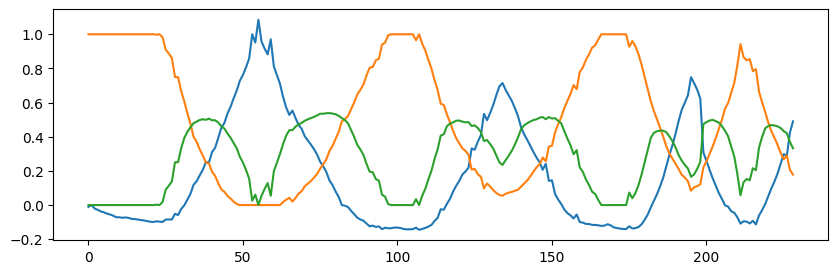

In [27]:
plt.figure(figsize=[10, 3])
plt.plot(mcrar.C_opt_)